In [11]:
import os

import numpy as np
import scipy as sp
from scipy import misc, stats
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
#import plotly.plotly as py
import seaborn as sns
from pandas import DataFrame, Series
import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

In [12]:
MAIN_TAG = 'portrait'
DIRNAME_TAGS = 'mirflickr25k/mirflickr/meta/tags'
DIRNAME_IMAGES = 'mirflickr25k/mirflickr'

COLOR = {'red': 0,
         'green': 1,
         'blue': 2}

In [13]:
from os import listdir
from matplotlib import image
import random
# load all images in a directory
np.random.RandomState(9)
random_indexes = np.random.choice(range(25000), 250)
loaded_images = list()
image_names = list()
for i in range(250):
	# load image
	randName = random_indexes[i]
	image_names.append(randName)
	filename = 'im' + str(randName) + '.jpg'
	img_data = image.imread('mirflickr25k/mirflickr/' + filename)
	# store loaded image
	loaded_images.append(img_data)
	print('> loaded %s %s' % (filename, img_data.shape))

> loaded im17851.jpg (500, 333, 3)
> loaded im1560.jpg (334, 500, 3)
> loaded im953.jpg (400, 500, 3)
> loaded im16096.jpg (500, 441, 3)
> loaded im16266.jpg (375, 500, 3)
> loaded im2857.jpg (333, 500, 3)
> loaded im17378.jpg (352, 500, 3)
> loaded im2199.jpg (327, 500, 3)
> loaded im11971.jpg (375, 500, 3)
> loaded im18739.jpg (333, 500, 3)
> loaded im7581.jpg (333, 500, 3)
> loaded im24437.jpg (500, 375, 3)
> loaded im16446.jpg (342, 500, 3)
> loaded im19006.jpg (333, 500, 3)
> loaded im18483.jpg (400, 500, 3)
> loaded im16947.jpg (431, 500, 3)
> loaded im13361.jpg (298, 500, 3)
> loaded im24687.jpg (500, 446, 3)
> loaded im15982.jpg (333, 500, 3)
> loaded im11249.jpg (500, 375, 3)
> loaded im513.jpg (500, 375, 3)
> loaded im22071.jpg (300, 500, 3)
> loaded im13325.jpg (331, 500, 3)
> loaded im12692.jpg (343, 500, 3)
> loaded im14732.jpg (333, 500, 3)
> loaded im8268.jpg (375, 500, 3)
> loaded im9509.jpg (500, 375, 3)
> loaded im10303.jpg (500, 335, 3)
> loaded im17946.jpg (343, 500

> loaded im1222.jpg (500, 332, 3)
> loaded im23968.jpg (333, 500, 3)
> loaded im11867.jpg (500, 500, 3)
> loaded im13731.jpg (500, 375, 3)
> loaded im12436.jpg (335, 500, 3)
> loaded im16717.jpg (500, 369, 3)
> loaded im20287.jpg (426, 500, 3)
> loaded im10583.jpg (333, 500, 3)
> loaded im12086.jpg (500, 336, 3)


In [14]:
len(image_names)

250

In [16]:
import codecs

Y = pd.Series()
for name in image_names:
    with codecs.open(os.path.join(DIRNAME_TAGS, 'tags%d.txt' % (name,)), "r", "utf_8_sig") as file:
        set_tags = set(tag.strip() for tag in file.readlines())
        #print('tags%d.txt' % (name,), '  ',set_tags)
        Y.at[name] = int(MAIN_TAG in set_tags)
Y = pd.DataFrame(Y, columns=['target'])

In [17]:
Y['target'].value_counts()

0    245
1      5
Name: target, dtype: int64

In [18]:
Y.head()

,target
17851,0
1560,0
953,0
16096,0
16266,0


## Static data

In [19]:
data_static = DataFrame()
num = 0
d = []
for image_name in image_names:
    image = np.array(Image.open(os.path.join(DIRNAME_IMAGES, 'im%d.jpg' % (image_name))))
    data = []
    for name, num in COLOR.items():
        a = image[:, :, num].ravel()
        data.extend([np.mean(a), np.var(a), sp.stats.skew(a), sp.stats.kurtosis(a)])
    d.append([image_name, *data])
    

data_static = pd.DataFrame.from_records(d)
data_static = data_static.rename(columns={0: 'name'}).set_index('name')

In [20]:
data_static.head()

,1,2,3,4,5,6,7,8,9,10,11,12
name,,,,,,,,,,,,
17851,155.872859,8144.377042,-0.506881,-1.517458,155.442474,8178.212336,-0.501321,-1.524746,154.636420,8244.023113,-0.490292,-1.539020
1560,109.895952,2802.180360,0.331099,-0.035741,74.300371,2199.924065,0.986046,0.613098,41.075263,1570.512377,1.729156,2.381395
953,92.943685,4125.821584,0.533105,-0.561011,75.856745,3599.590003,0.621581,-0.462403,78.522475,3635.143155,0.608588,-0.532272
16096,109.820317,6426.460549,0.456630,-1.237777,96.406766,5115.084809,0.703603,-0.762189,98.590281,5658.242901,0.821757,-0.585429
16266,142.641515,5343.976235,-0.432756,-1.200493,126.054080,5364.088862,-0.259871,-1.263412,111.646075,3873.665942,-0.077387,-0.876574


In [21]:
data_static.shape

(250, 12)

# Learning

In [22]:
import itertools

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [23]:
N = 12

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

## Static

In [25]:
X = data_static.copy()

df = Y.join(X, how='inner')
df = df.drop_duplicates()

y = df['target']
X = df.drop('target', axis=1)

Normalized confusion matrix
[[0.92424242 0.07575758]
 [0.54545455 0.45454545]]


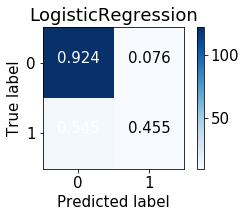

Normalized confusion matrix
[[0.08163265 0.91836735]
 [0.16666667 0.83333333]]


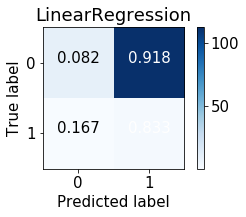

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


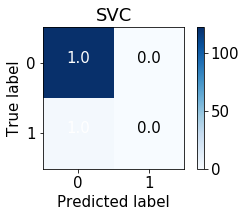

In [27]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = c()
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                          title=c.__name__)
    plt.savefig("static_" + c.__name__ + ".png")
    plt.show()


## SPAM

Normalized confusion matrix
[[0.92481203 0.07518797]
 [0.54545455 0.45454545]]


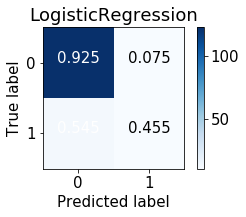

[[123  10]
 [ 12  10]]
Normalized confusion matrix
[[9.99316940e-01 6.83060109e-04]
 [1.00000000e+00 0.00000000e+00]]


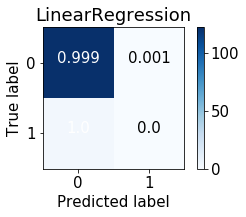

[[1.21916667e+02 8.33333333e-02]
 [3.00000000e+00 0.00000000e+00]]
Normalized confusion matrix
[[9.99319265e-01 6.80735194e-04]
 [1.00000000e+00 0.00000000e+00]]


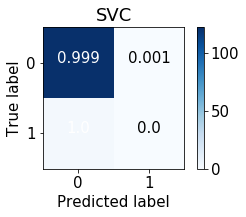

[[1.22333333e+02 8.33333333e-02]
 [2.58333333e+00 0.00000000e+00]]


In [28]:
for c in (LogisticRegression, LinearRegression, SVC):
    cls = LinearRegression(n_jobs=-1)
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test).astype(int)
        #print(y_predict)
   
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int))) # .astype(int)
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("spam" + c.__name__ + ".png")
    plt.show()
    print(cnf_matrix)

## CCPEV

Normalized confusion matrix
[[0.99659864 0.00340136]
 [1.         0.        ]]


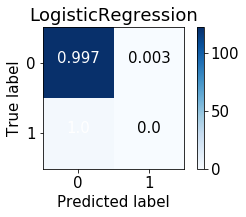

Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


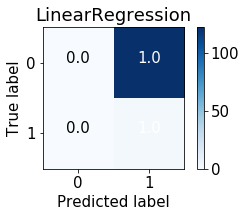

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


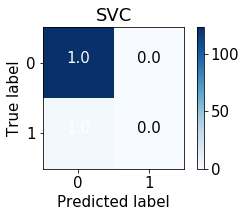

In [29]:
for c in (LogisticRegression, LinearRegression, SVC):
    cnf_matrix = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        cls = c()
        cls.fit(X_train, y_train)
        y_predict = cls.predict(X_test)
        cnf_matrix.append(confusion_matrix(y_test, y_predict.astype(bool).astype(int)))
    #print(confusion_matrix(y_test, y_predict.astype(int)))
    cnf_matrix = np.mean(np.array(cnf_matrix), axis=0)
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                              title=c.__name__)
    plt.savefig("ccpev_" + c.__name__ + ".png")
    plt.show()
    #print(cnf_matrix)